# Compare metadata dumps

In [1]:
from dataclasses import asdict
from datetime import datetime
from typing import Any

import h5py
import hdf5plugin
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

from common import get_data_directory

from allisbns.dataset import BinnedArray, CodeDataset, PackedCodes
from allisbns.errors import InvalidISBNError
from allisbns.isbn import (
    LAST_ISBN,
    MaskedISBN,
    normalize_isbn,
    validate_isbn,
)
from allisbns.merge import difference
from allisbns.plotting import BlockBinnedPlotter


%load_ext autoreload
%autoreload 2

## Load data

In [2]:
all_input_paths = sorted(get_data_directory().glob("*.benc.zst"))
all_input_paths

[PosixPath('/home/ms/projects/python/allisbns/examples/data/aa_isbn13_codes_20251118T170842Z.benc.zst'),
 PosixPath('/home/ms/projects/python/allisbns/examples/data/aa_isbn13_codes_20251222T170326Z.benc.zst')]

## Compare datasets

In [3]:
previous_path, last_path, *_ = all_input_paths
previous_path, last_path

(PosixPath('/home/ms/projects/python/allisbns/examples/data/aa_isbn13_codes_20251118T170842Z.benc.zst'),
 PosixPath('/home/ms/projects/python/allisbns/examples/data/aa_isbn13_codes_20251222T170326Z.benc.zst'))

In [4]:
extract_timestamp = lambda x: x.removesuffix(".benc.zst").split("_")[-1]

In [5]:
previous_timestamp = extract_timestamp(previous_path.name)
last_timestamp = extract_timestamp(last_path.name)
datetime.fromisoformat(last_timestamp) - datetime.fromisoformat(previous_timestamp)

datetime.timedelta(days=33, seconds=86084)

In [6]:
datasets_to_compare = [
    CodeDataset.from_file(path, "md5", fill_to_isbn=LAST_ISBN)
    for path in (previous_path, last_path)
]
datasets_to_compare

[CodeDataset(array([     6,      1,      9, ...,  91739,      1, 531099],
       shape=(14737376,)), bounds=(978000000000, 979999999999)),
 CodeDataset(array([     6,      1,      9, ...,  91739,      1, 531099],
       shape=(14754228,)), bounds=(978000000000, 979999999999))]

In [7]:
previous, last = datasets_to_compare
previous.count_filled_isbns(), last.count_filled_isbns()

(16916212, 16964933)

In [8]:
dataset_additions = difference([last, previous])
with np.printoptions(threshold=0):
    display(dataset_additions)

CodeDataset(array([        0,    215095,         1, ...,   9247831,         1,
       100838168], shape=(63226,), dtype=int32), bounds=(978000000000, 979999999999))

In [9]:
dataset_deletions = difference([previous, last])
with np.printoptions(threshold=0):
    display(dataset_deletions)

CodeDataset(array([         0,   40602658,          1, ...,   12603311,          1,
       1000623106], shape=(454,), dtype=int32), bounds=(978000000000, 979999999999))

In [10]:
(dataset_additions.count_filled_isbns(), dataset_deletions.count_filled_isbns())

(48963, 242)

## Plot binned images

In [11]:
bin_size = 2000

### Additions

In [12]:
binned_additions = dataset_additions.bin(bin_size)
addition_mask = np.where(binned_additions.bins > 0, True, False)
addition_mask

array([False, False, False, ..., False, False, False], shape=(1000000,))

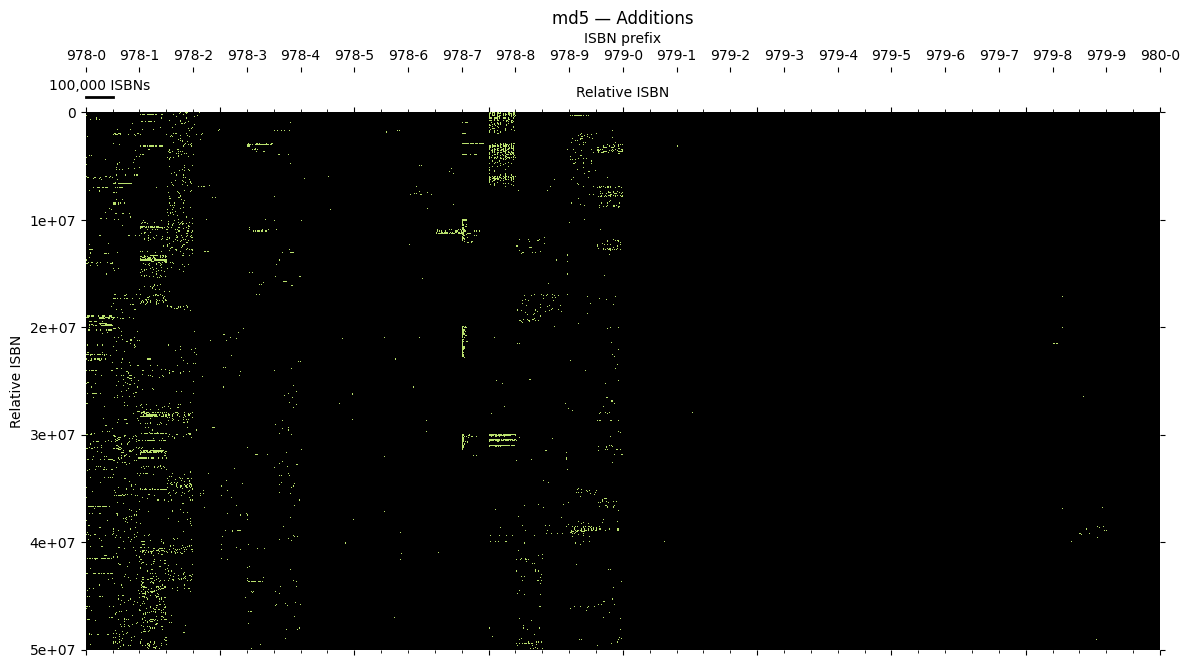

In [13]:
fig, ax = plt.subplots(figsize=(12, 12))

binned_addition_mask = BinnedArray(addition_mask, bin_size=bin_size)

plotter = BlockBinnedPlotter(ax, bin_size=bin_size, aspect=2)
plotter.plot_bins(
    binned_addition_mask,
    colormap=mpl.colors.ListedColormap(["#bbe26e"]),
    show_colorbar=False,
    vmin=0,
    vmax=1,
)

ax.set_facecolor("k")

plt.title("md5 — Additions")

plt.tight_layout()
plt.show()

### Deletions

In [14]:
binned_deletions = dataset_deletions.bin(bin_size)
deletion_mask = np.where(binned_deletions.bins > 0, True, False)
deletion_mask

array([False, False, False, ..., False, False, False], shape=(1000000,))

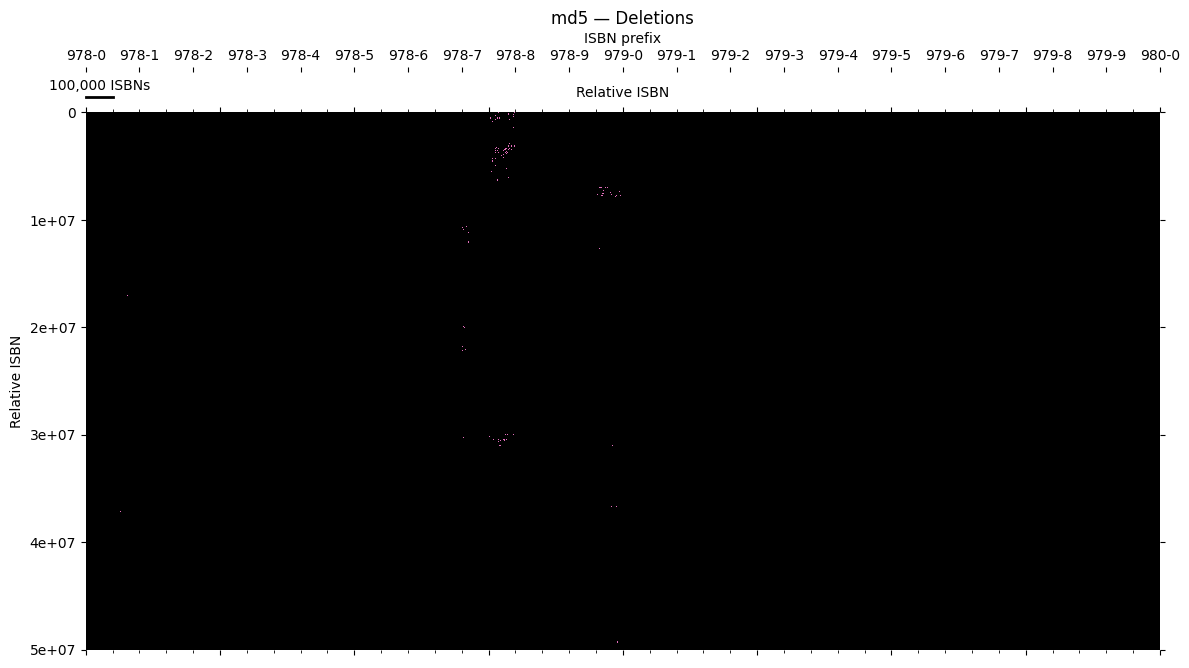

In [15]:
fig, ax = plt.subplots(figsize=(12, 12))

binned_deletion_mask = BinnedArray(deletion_mask, bin_size=bin_size)

plotter = BlockBinnedPlotter(ax, bin_size=bin_size, aspect=2)
plotter.plot_bins(
    binned_deletion_mask,
    colormap=mpl.colors.ListedColormap(["#e26ebb"]),
    show_colorbar=False,
    vmin=0,
    vmax=1,
)

ax.set_facecolor("k")

plt.title("md5 — Deletions")

plt.tight_layout()
plt.show()

## Save results to HDF5

In [16]:
def normalize_codes(codes: PackedCodes) -> PackedCodes:
    """Ensures that codes end with a streak segment."""
    if len(codes) % 2 == 0:
        return codes[:-1]
    return codes


compression = hdf5plugin.Blosc(cname="zstd", shuffle=hdf5plugin.Blosc.SHUFFLE)

output_path = (
    get_data_directory()
    / f"xy_isbn13_codes_diff_{previous_timestamp}--{last_timestamp}.h5"
)
print(output_path)

with h5py.File(output_path, "w") as h5:
    h5.attrs["a"] = previous_path.name
    h5.attrs["b"] = last_path.name

    if dataset_additions.count_filled_isbns() > 0:
        group = h5.create_group("additions")
        array = group.create_dataset(
            name="md5",
            data=normalize_codes(dataset_additions.codes),
            compression=compression,
        )
        # In case if we work with cropped datasets
        array.attrs["offset"] = dataset_additions.offset

    if dataset_deletions.count_filled_isbns() > 0:
        group = h5.create_group("deletions")
        array = group.create_dataset(
            name="md5",
            data=normalize_codes(dataset_deletions.codes),
            compression=compression,
        )
        array.attrs["offset"] = dataset_deletions.offset

/home/ms/projects/python/allisbns/examples/data/xy_isbn13_codes_diff_20251118T170842Z--20251222T170326Z.h5


In [17]:
# Requires the hdf5 package
!h5dump -A $output_path

HDF5 "/home/ms/projects/python/allisbns/examples/data/xy_isbn13_codes_diff_20251118T170842Z--20251222T170326Z.h5" {
GROUP "/" {
   ATTRIBUTE "a" {
      DATATYPE  H5T_STRING {
         STRSIZE H5T_VARIABLE;
         STRPAD H5T_STR_NULLTERM;
         CSET H5T_CSET_UTF8;
         CTYPE H5T_C_S1;
      }
      DATASPACE  SCALAR
      DATA {
      (0): "aa_isbn13_codes_20251118T170842Z.benc.zst"
      }
   }
   ATTRIBUTE "b" {
      DATATYPE  H5T_STRING {
         STRSIZE H5T_VARIABLE;
         STRPAD H5T_STR_NULLTERM;
         CSET H5T_CSET_UTF8;
         CTYPE H5T_C_S1;
      }
      DATASPACE  SCALAR
      DATA {
      (0): "aa_isbn13_codes_20251222T170326Z.benc.zst"
      }
   }
   GROUP "additions" {
      DATASET "md5" {
         DATATYPE  H5T_STD_I32LE
         DATASPACE  SIMPLE { ( 63225 ) / ( 63225 ) }
         ATTRIBUTE "offset" {
            DATATYPE  H5T_STD_I64LE
            DATASPACE  SCALAR
            DATA {
            (0): 978000000000
            }
         }
      }
   

In [18]:
with h5py.File(output_path, "r") as h5:
    additions = h5["/additions/md5"][:]
CodeDataset(additions)

CodeDataset(array([      0,  215095,       1, ...,       2, 9247831,       1],
      shape=(63225,), dtype=int32), bounds=(978000000000, 979899161831))

## Get largest groups and registrants

In [19]:
added_isbn12s = dataset_additions.get_filled_isbns()
added_isbn12s

array([978000215095, 978000255927, 978000400018, ..., 979889913998,
       979889913999, 979899161831], shape=(48963,))

In [20]:
def process_isbn(x: int) -> dict[str, Any]:
    try:
        canonical_isbn = normalize_isbn(x)
        masked_isbn = MaskedISBN.from_canonical(canonical_isbn)
        return {
            "canonical": str(canonical_isbn),
            "formatted": masked_isbn.hyphenate(),
            **asdict(masked_isbn),
        }
    except InvalidISBNError:
        return {
            "canonical": str(canonical_isbn),
        }


isbns_df = pl.DataFrame({"isbn12": added_isbn12s})

isbns_df = isbns_df.with_columns(
    columns=pl.col("isbn12").map_elements(
        process_isbn,
        skip_nulls=True,
        return_dtype=pl.Struct(
            {
                "canonical": pl.String,
                "formatted": pl.String,
                "bookland": pl.String,
                "group": pl.String,
                "registrant": pl.String,
                "publication": pl.String,
                "check_digit": pl.String,
            }
        ),
    )
).unnest("columns")
isbns_df

isbn12,canonical,formatted,bookland,group,registrant,publication,check_digit
i64,str,str,str,str,str,str,str
978000215095,"""9780002150958""","""978-0-00-215095-8""","""978""","""0""","""00""","""215095""","""8"""
978000255927,"""9780002559270""","""978-0-00-255927-0""","""978""","""0""","""00""","""255927""","""0"""
978000400018,"""9780004000183""","""978-0-00-400018-3""","""978""","""0""","""00""","""400018""","""3"""
978000400019,"""9780004000190""","""978-0-00-400019-0""","""978""","""0""","""00""","""400019""","""0"""
978000400021,"""9780004000213""","""978-0-00-400021-3""","""978""","""0""","""00""","""400021""","""3"""
…,…,…,…,…,…,…,…
979889913089,"""9798899130892""","""979-8-89913-089-2""","""979""","""8""","""89913""","""089""","""2"""
979889913090,"""9798899130908""","""979-8-89913-090-8""","""979""","""8""","""89913""","""090""","""8"""
979889913998,"""9798899139987""","""979-8-89913-998-7""","""979""","""8""","""89913""","""998""","""7"""


In [21]:
(
    isbns_df.filter(pl.col("formatted").is_null())
    .select("isbn12")
    .with_columns(
        errors=pl.col("isbn12").map_elements(
            lambda x: validate_isbn(normalize_isbn(x), return_reasons=True)[1],
            return_dtype=pl.List(pl.String),
        )
    )
)

isbn12,errors
i64,list[str]
978637294607,"[""bad_group""]"
978661006238,"[""bad_group""]"
978661007146,"[""bad_group""]"
978661016742,"[""bad_group""]"
978661021760,"[""bad_group""]"
…,…
978978756631,"[""bad_registrant""]"
979080164001,"[""bad_group""]"
979080164003,"[""bad_group""]"


In [22]:
valid_isbns_df = isbns_df.filter(pl.col("formatted").is_not_null())
valid_isbns_df

isbn12,canonical,formatted,bookland,group,registrant,publication,check_digit
i64,str,str,str,str,str,str,str
978000215095,"""9780002150958""","""978-0-00-215095-8""","""978""","""0""","""00""","""215095""","""8"""
978000255927,"""9780002559270""","""978-0-00-255927-0""","""978""","""0""","""00""","""255927""","""0"""
978000400018,"""9780004000183""","""978-0-00-400018-3""","""978""","""0""","""00""","""400018""","""3"""
978000400019,"""9780004000190""","""978-0-00-400019-0""","""978""","""0""","""00""","""400019""","""0"""
978000400021,"""9780004000213""","""978-0-00-400021-3""","""978""","""0""","""00""","""400021""","""3"""
…,…,…,…,…,…,…,…
979889913089,"""9798899130892""","""979-8-89913-089-2""","""979""","""8""","""89913""","""089""","""2"""
979889913090,"""9798899130908""","""979-8-89913-090-8""","""979""","""8""","""89913""","""090""","""8"""
979889913998,"""9798899139987""","""979-8-89913-998-7""","""979""","""8""","""89913""","""998""","""7"""


### Largest groups

In [23]:
grouped_by_group_df = (
    valid_isbns_df.group_by("bookland", "group")
    .agg("formatted", pl.len().alias("count"))
    .sort("count", descending=True)
)
grouped_by_group_df.head(10)

bookland,group,formatted,count
str,str,list[str],u32
"""978""","""1""","[""978-1-000-05976-2"", ""978-1-000-17375-8"", … ""978-1-992121-41-6""]",15092
"""978""","""7""","[""978-7-00-000000-1"", ""978-7-01-000126-5"", … ""978-7-988131-94-0""]",5966
"""978""","""0""","[""978-0-00-215095-8"", ""978-0-00-255927-0"", … ""978-0-9992307-0-1""]",5741
"""979""","""8""","[""979-8-200-13317-8"", ""979-8-200-13318-5"", … ""979-8-9916183-1-1""]",5490
"""978""","""93""","[""978-93-331-9194-4"", ""978-93-5004-008-9"", … ""978-93-95736-57-2""]",3066
"""978""","""953""","[""978-953-0-60705-7"", ""978-953-0-60710-1"", … ""978-953-98709-1-9""]",2900
"""978""","""3""","[""978-3-00-034911-9"", ""978-3-030-05323-9"", … ""978-3-99043-226-6""]",2163
"""978""","""81""","[""978-81-19132-05-8"", ""978-81-19403-02-8"", … ""978-81-983333-9-1""]",1696
"""978""","""958""","[""978-958-35-0808-0"", ""978-958-35-1070-0"", … ""978-958-99123-0-0""]",1159


### Largest registrants

In [24]:
grouped_by_registrant_df = (
    valid_isbns_df.group_by("bookland", "group", "registrant")
    .agg("formatted", pl.len().alias("count"))
    .sort("count", descending=True)
)
grouped_by_registrant_df.head(10)

bookland,group,registrant,formatted,count
str,str,str,list[str],u32
"""978""","""1""","""9846""","[""978-1-9846-0028-8"", ""978-1-9846-0029-5"", … ""978-1-9846-9409-6""]",2557
"""978""","""3""","""437""","[""978-3-437-05417-4"", ""978-3-437-05807-3"", … ""978-3-437-59792-3""]",1177
"""978""","""0""","""19""","[""978-0-19-005019-1"", ""978-0-19-005030-6"", … ""978-0-19-999643-8""]",1141
"""978""","""81""","""265""","[""978-81-265-0576-0"", ""978-81-265-0598-2"", … ""978-81-265-9997-4""]",746
"""979""","""8""","""89200""","[""979-8-89200-006-2"", ""979-8-89200-007-9"", … ""979-8-89200-999-7""]",720
"""978""","""609""","""02""","[""978-609-02-0002-5"", ""978-609-02-0003-2"", … ""978-609-02-1879-2""]",703
"""979""","""8""","""89213""","[""979-8-89213-001-1"", ""979-8-89213-004-2"", … ""979-8-89213-999-1""]",679
"""978""","""953""","""14""","[""978-953-14-0902-5"", ""978-953-14-0906-3"", … ""978-953-14-3851-3""]",653
"""979""","""8""","""88822""","[""979-8-88822-000-9"", ""979-8-88822-001-6"", … ""979-8-88822-996-5""]",576
